In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys 
from skimage import data, io, filters
import configparser
import pandas as pd 
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import argparse

from matplotlib import cycler
from os.path import join as oj
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import pickle as pkl
from sklearn.preprocessing import StandardScaler,MinMaxScaler
sys.path.insert(0, "../src")

from torch import optim
from torch.utils.data import DataLoader, TensorDataset
import my_data
from utils.dice_score import dice_loss
from evaluate import evaluate,random_cost,uncertainty_cost
from unet import UNet
from predict import predict_img
import seaborn as sns
import pickle as pkl
pd.set_option('display.float_format', lambda x: '%.2f' % x)
cuda = False # torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
config = configparser.ConfigParser()
config.read('../config.ini');
data_path =config['DATASET']['data_path'] 
from torch.nn import functional as F

In [2]:
fnames = sorted([oj(config['PATHS']['model_path'] , fname) for fname in os.listdir(config['PATHS']['model_path'] ) if "pkl" in fname]) 
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 


In [3]:
results = pd.concat(results_list, axis=1).T.infer_objects()

results.experiment_name.unique()
results['best_val_score'] = [max(x) for x in results.val_scores]

In [19]:
from numpy.random import normal

In [20]:
run_folder = oj(config["PATHS"]["progress_results"], str('1317850316'))
args = pkl.load(open(oj(run_folder, "args.pkl"), "rb"))
results = pkl.load(open(oj(run_folder, "results.pkl"), "rb"))

In [38]:
results

{'file_name': '1317850316',
 'epochs': 50,
 'batch_size': 128,
 'cost_function': 'uncertainty_cost',
 'add_ratio': 0.1,
 'foldername': 'lno_halfHour',
 'poolname': 'lno_human',
 'experiment_name': 'TestDebug23',
 'lr': 0.01,
 'image_size': 128,
 'offset': 128,
 'seed': 2,
 'scale': 0.5,
 'val': 10,
 'amp': False,
 'add_step': 20,
 'bilinear': False,
 'classes': 6,
 'val_scores': [0.45081278681755066,
  0.28354406356811523,
  0.3303016424179077,
  0.4043194651603699,
  0.39536064863204956,
  0.4173584282398224,
  0.45296257734298706,
  0.4684542119503021,
  0.4938570559024811,
  0.41113752126693726,
  0.48803892731666565,
  0.4904911518096924,
  0.5108752250671387,
  0.5273743271827698,
  0.5375432372093201,
  0.5368372201919556,
  0.5520991086959839,
  0.5506550073623657,
  0.5655754804611206,
  0.5482434630393982],
 'num_classes': 3}

In [22]:
best_idx = 0

In [23]:
results['file_name']

'1317850316'

In [24]:
net = UNet(1, results['num_classes'], bilinear = results['bilinear']).to(device)
# my_models = [UNet(1, 3, bilinear = results_all.bilinear[0]).to(device) for i, _ in enumerate(results.file_name)] 

net.load_state_dict(torch.load(oj(config['PATHS']['progress_results'] ,results['file_name'], "model_state.pt")))
net = net.to(device).eval()

In [25]:
x,y,num_classes, class_dict = my_data.load_layer_data(oj(data_path, results['foldername']))

x, y = x[:-4], y[:-4]  # just don't touch the last four
x = x/x.max()
val_percent = .25
init_train_ratio =1
image_size = 128
offset = 64
all_idxs = np.arange(len(x))
np.random.seed(0)
np.random.shuffle(all_idxs)
n_val = np.maximum(int(len(x) * val_percent), 1)
n_train = len(x) - n_val
all_train_idxs = all_idxs[:n_train]
val_idxs = all_idxs[n_train:]
init_train_idxs = all_train_idxs[: np.maximum(1, int(init_train_ratio * n_train))]
pool_idxs = all_train_idxs[np.maximum(1, int(init_train_ratio * n_train)) :]



In [28]:
len(annotated_set)

NameError: name 'annotated_set' is not defined

In [29]:
x[val_idxs[img_idx]][None, ][:,:]

NameError: name 'img_idx' is not defined

In [30]:
output.shape

NameError: name 'output' is not defined

In [31]:
annotated_set = my_data.load_annotated_imgs(oj(config["PATHS"]["progress_results"], '1317850316'))

In [34]:
test_input_annot =annotated_set[0][0][0].numpy()
test_img_np  = ((test_input_annot[None, None].astype(np.float32) ))
with torch.no_grad():
    img_t = torch.Tensor(test_img_np).to(device)
    output = net.forward(img_t).cpu().detach().numpy()[0]

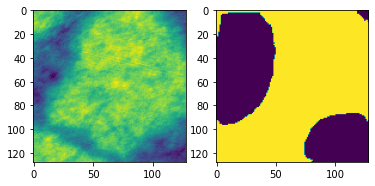

In [35]:
fig, ax = plt.subplots(ncols =2)
ax[0].imshow(test_img_np[0,0])
ax[1].imshow(np.argmax(output, axis=0))

(array([5.52269663e-02, 4.36795097e-01, 1.74718039e+00, 1.37849855e+01,
        5.51098632e+00, 3.73535117e+00, 1.66015608e+00, 3.69853320e-01,
        1.05433299e-01, 1.33883555e-02]),
 array([0.27058825, 0.30705884, 0.34352943, 0.38000003, 0.41647062,
        0.45294118, 0.48941177, 0.52588236, 0.56235296, 0.59882355,
        0.63529414], dtype=float32),
 <BarContainer object of 10 artists>)

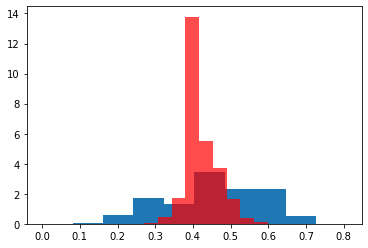

In [100]:
test_img = x[val_idxs[img_idx]][None, ]
plt.hist(test_img.reshape(-1), density = True)
plt.hist(test_input_annot.reshape(-1), density = True, color= 'r', alpha =.7)

In [36]:
img_idx = 7
test_img_np_old  = ((x[val_idxs[img_idx]][None, ][:,:,:128,:128].astype(np.float32) ))
with torch.no_grad():
    img_t = torch.Tensor(test_img_np_old).to(device)
    output = net.forward(img_t).cpu().detach().numpy()[0]

Text(0.5, 1.0, 'Difference')

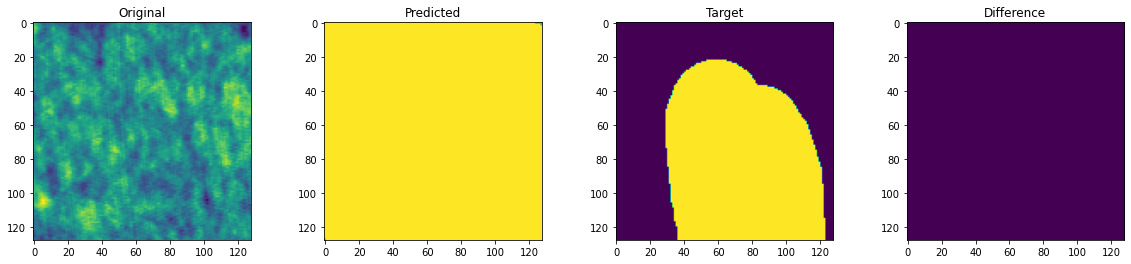

In [37]:
fig, axes = plt.subplots(ncols = 4, figsize = (20,4))
axes[0].imshow(x[val_idxs[img_idx]][0][:128,:128,])
axes[1].imshow(np.argmax(output, axis=0),vmin =-1, vmax = 2)
target = np.copy(y[val_idxs[img_idx]]).astype(np.int16)
target[np.where(target == 255)] =-1
axes[2].imshow(target[:128,:128], vmin =-1,vmax = 2)
axes[3].imshow((target[:128,:128] !=np.argmax(output, axis=0) ) * (target[:128,:128] !=-1))
axes[0].set_title("Original")
axes[1].set_title("Predicted")
axes[2].set_title("Target")
axes[3].set_title("Difference")
# axes[1].imshow()

# try with detailed

In [16]:
x,y,num_classes = my_data.load_layer_data(oj(data_path, 'lno'))

x, y = x[:-4], y[:-4]  # just don't touch the last four
x = x/x.max()
val_percent = .25
init_train_ratio =1
image_size = 128
offset = 64
all_idxs = np.arange(len(x))
np.random.seed(0)
np.random.shuffle(all_idxs)
n_val = np.maximum(int(len(x) * val_percent), 1)
n_train = len(x) - n_val
all_train_idxs = all_idxs[:n_train]
val_idxs = all_idxs[n_train:]
init_train_idxs = all_train_idxs[: np.maximum(1, int(init_train_ratio * n_train))]
pool_idxs = all_train_idxs[np.maximum(1, int(init_train_ratio * n_train)) :]

val_set = TensorDataset(
    *[
        torch.Tensor(input)
        for input in my_data.make_dataset(
            x[val_idxs[:1]],
            y[val_idxs[:1]],
            img_size=image_size,
            offset=image_size,
        )
    ]
)
val_loader = DataLoader(val_set, shuffle=False, drop_last=False, batch_size = 16)

In [17]:
torch.unique(val_set[0][1])

tensor([0., 1.])

In [18]:
torch.unique(val_set[0][1].min())

tensor([0.])

In [19]:
torch.unique(testDataset[0][1])

NameError: name 'testDataset' is not defined

In [ ]:
x_small, _,=my_data.make_dataset(
            x[val_idxs[:1]],
            y[val_idxs[:1]],
            img_size=image_size,
            offset=image_size,
        )

In [19]:
type(x_small)

numpy.ndarray

In [12]:
testDataset = my_data.load_annotated_img(oj(config["PATHS"]["progress_results"], '424242'))

In [13]:
testDataset

In [44]:
x_small[test_idxes].min()

0.23921568627450981

In [ ]:
net(t)

In [38]:
x.shape

(20, 1, 1024, 1024)

In [ ]:
val_loader

In [21]:
def get_args():
    parser = argparse.ArgumentParser(description="Train the UNet on images and target masks")
    parser.add_argument("--epochs", "-e", type=int, default=1)
    parser.add_argument("--batch-size", "-b", dest="batch_size", type=int, default=2,)
    parser.add_argument("--cost_function", dest="cost_function", type=str, default="random_cost",)
    parser.add_argument("--add_ratio", type=float, default=0.1,)
    parser.add_argument("--foldername", type=str, default="lno_halfHour",)
    
    parser.add_argument("--poolname", type=str, default="lno",)
    parser.add_argument("--experiment_name", "-g", type=str, default="",)
    parser.add_argument("--learningrate", "-l", type=float, default=1e-5, dest="lr",)
    parser.add_argument("--image-size", dest="image_size", type=int, default=128, )
    parser.add_argument("--offset", dest="offset", type=int, default=64,)
    parser.add_argument("--seed", "-t", type=int, default=42,)
    parser.add_argument("--scale", "-s", type=float, default=0.5, help="Downscaling factor of the images",)
    parser.add_argument("--validation", "-v", dest="val", type=int, default=10, help="Val percentage (0-100)", )
    parser.add_argument("--amp", action="store_true", default=False, help="Use mixed precision")
    parser.add_argument("--add_step", type=int, default=1)
    parser.add_argument("--human_annotation", action="store_true", default=False, help="Expect unannotated dataset")
    parser.add_argument("--bilinear", action="store_true", default=False, help="Use bilinear upsampling")
    parser.add_argument("--classes", "-c", type=int, default=6, help="Number of classes")
    return parser.parse_args("")

In [63]:
args = get_args()

In [67]:
x_small[test_idxes].shape

(4, 1, 128, 128)

In [64]:
args

Namespace(epochs=1, batch_size=2, cost_function='random_cost', add_ratio=0.1, foldername='lno_halfHour', poolname='lno', experiment_name='', lr=1e-05, image_size=128, offset=64, seed=42, scale=0.5, val=10, amp=False, add_step=1, human_annotation=False, bilinear=False, classes=6)

In [ ]:
len(all_train_idxs)

In [ ]:
len(val_loader.dataset)

In [ ]:
plt.imshow(x[val_idxs[0]][0])

In [ ]:
test_ids_safe = std_cost_function(net, device,val_loader,n_choose =59)

# test_ids = np.argsort(test_ids_safe)